In [1]:
%matplotlib inline

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

lib_path = os.path.join('../src/lib')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = os.path.join('../src/')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = '../../Rotated_IoU/'
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
import json
import cv2
from glob import glob
import math
import numpy as np
import time
from progress.bar import Bar
import torch

import matplotlib.pyplot as plt
from PIL import Image

from external.nms import soft_nms
from fhd_opts import opts
from logger import Logger
from utils.utils import AverageMeter
from datasets.dataset_factory import dataset_factory
from detectors.detector_factory import detector_factory
from models.losses import _transpose_and_gather_feat
from models.Rotated_IoU.oriented_iou_loss import cal_diou, cal_giou, cal_iou

Using tensorboardX


In [4]:
class PrefetchDataset(torch.utils.data.Dataset):
  def __init__(self, opt, dataset, pre_process_func):
    self.images = dataset.images
    self.load_image_func = dataset.coco.loadImgs
    self.img_dir = dataset.img_dir
    self.pre_process_func = pre_process_func
    self.opt = opt
  
  def __getitem__(self, index):
    img_id = self.images[index]
    img_info = self.load_image_func(ids=[img_id])[0]
    img_path = os.path.join(self.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    images, meta = {}, {}
    for scale in opt.test_scales:
      if opt.task == 'ddd':
        images[scale], meta[scale] = self.pre_process_func(
          image, scale, img_info['calib'])
      else:
        images[scale], meta[scale] = self.pre_process_func(image, scale)
    return img_id, {'images': images, 'image': image, 'meta': meta}

  def __len__(self):
    return len(self.images)

def prefetch_test(opt):
  os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str

  Dataset = dataset_factory[opt.dataset]
  opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
  print(opt)
  Logger(opt)
  Detector = detector_factory[opt.task]
  
  split = 'val' if not opt.trainval else 'test'
  dataset = Dataset(opt, split)
  detector = Detector(opt)
  
  data_loader = torch.utils.data.DataLoader(
    PrefetchDataset(opt, dataset, detector.pre_process), 
    batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

  results = {}
  num_iters = len(dataset)
  bar = Bar('{}'.format(opt.exp_id), max=num_iters)
  time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
  avg_time_stats = {t: AverageMeter() for t in time_stats}
  for ind, (img_id, pre_processed_images) in enumerate(data_loader):
    ret = detector.run(pre_processed_images)
    results[img_id.numpy().astype(np.int32)[0]] = ret['results']
    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(
                   ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
      avg_time_stats[t].update(ret[t])
      Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
        t, tm = avg_time_stats[t])
    bar.next()
  bar.finish()
  dataset.run_eval(results, opt.save_dir)

In [5]:
args = ['eldet']
opt = opts().parse(args)
# opt.data_dir = '/data/cc/Data/CHD/fake_data/'
# opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/fake_0214_eldet_fhd_dla_iouw5_nocrop_896x608/model_last.pth'
# opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/fake_0209_eldet_fhd_dla_rl_nocrop_896x608/model_best.pth'
opt.data_dir = '/data/cc/Data/CHD/detection/'
opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/exp3_base_theta5_iou/model_last.pth'
opt.num_classes = 2
opt.dataset = 'coco_fhd'
opt.resume = True
opt.gpus_str = '5'

torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = dataset_factory[opt.dataset]
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

exp_name = opt.load_model.split('/')[-2]
save_pred_folder = os.path.join('../exp/prediction/', exp_name)
if not os.path.exists(save_pred_folder):
    os.makedirs(save_pred_folder)
    
print(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default
heads {'hm': 2, 'reg': 2, 'l': 1, 'ratio_al': 1, 'ratio_bl': 1, 'theta': 1, 'sincos': 2}
Namespace(K=2, aggr_weight=0.0, agnostic_ex=False, angle_bins_weight=0, arch='dla_34', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/cc/Data/CHD/detection/', dataset='coco_fhd', debug=0, debug_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, dim_weight=1, down_ratio=4, ellipse_reg_weight=0, ellipse_weight=1, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet', exp_id='default', fix_res=True,

In [8]:
Detector = detector_factory[opt.task]
split = 'val'
# split = 'train'
# opt.mean = [0, 0, 0]
# opt.std = [1, 1, 1]
print(opt.mean, opt.std)
dataset = Dataset(opt, split)
detector = Detector(opt)

model = detector.model

[[[0.216 0.216 0.216]]] [[[0.222 0.222 0.222]]]
==> initializing Fetal Heart Disease val data.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded val 417 samples
Creating model...
loaded /data/cc/workspace/Repository/CenterNet/exp/eldet/exp3_base_theta5_iou/model_last.pth, epoch 344


In [9]:
ind = 0
img_id = dataset.images[ind]
img_info = dataset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(dataset.img_dir, img_info['file_name'])
print(img_path)

image = cv2.imread(img_path)

/data/cc/Data/CHD/detection/images/normal_0003.png


In [10]:
ret = detector.run(img_path)
ret

/home/cc/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


{'results': {1: array([[ 6.0708961e+01, -6.7859993e+01,  9.9511987e+02,  8.6655090e+02,
           5.2791443e+02,  3.9934546e+02,  9.3441089e+02,  7.2774559e-01,
           6.8294001e-01, -4.7140598e-01, -1.5526435e-01,  1.1694402e-01,
           8.5105705e-01]], dtype=float32),
  2: array([[ 2.9612418e+02,  3.3623119e+01,  7.4247394e+02,  4.7997293e+02,
           5.1929907e+02,  2.5679800e+02,  4.4634979e+02,  7.8611207e-01,
           6.1427921e-01,  1.7749281e-01, -8.0613390e-02, -3.7832953e-02,
           7.7176607e-01]], dtype=float32)},
 'tot': 1.068162202835083,
 'load': 0.02400350570678711,
 'pre': 0.020003080368041992,
 'net': 1.0161545276641846,
 'dec': 0.004000663757324219,
 'post': 0.004000425338745117,
 'merge': 0.0}

# With Ground Truth

In [11]:
ann = anns[class_idx]
cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
ratio_al, ratio_ba = a_gt / l_gt, b_gt / a_gt
angle_gt = theta_gt * 180
print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l, ratio_al, ratio_ba, theta_gt, a_gt, b_gt, int(angle_gt))

NameError: name 'anns' is not defined

In [11]:
min(thetas), max(thetas)

(-0.34587318389231014, 0.4469070802020421)

In [144]:
image.shape

(360, 480, 3)

In [229]:
ell1 = [cx, cy, a, b, angle]
ell2 = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
ell1, ell2

([271, 257, 78.13416111469269, 54.25057339668274, 37.65756279230118],
 [271, 260, 41.6, 50.313, -29.025620983028098])

In [235]:
iouloss, bboxiou = compute_rotated_bbox_iou(ell1, ell2)

In [236]:
bboxiou.item()

0.488799124956131

In [223]:
compute_single_class_metric(ell1, ell2, shape)

(0.6571257002316224, 0.48934267365528195, 66.68318377532927)

In [12]:
# Calculate Metrics: Dice and difference of angles
# input 2 ellipse ell1, ell2 in [cx, cy, a, b, angle], image shape [h, w], num_classes

def compute_dice(pred, label):
    
    ints = np.sum((pred == 1) * (label == 1))
    sums = np.sum(pred == 1) + np.sum(label == 1) + 1e-5
    
    return (2.0 * ints) / sums

def compute_iou(pred, label):
    
    inter = np.sum((pred == 1) * (label == 1))
    union = np.sum((pred == 1) + (label == 1)) + 1e-5
    
    return inter / union

def compute_rotated_bbox_iou(ell1, ell2):
    cx1, cy1, a1, b1, angle1 = ell1
    cx2, cy2, a2, b2, angle2 = ell2
    theta1 = angle1 / 180.0 * math.pi
    theta2 = angle2 / 180.0 * math.pi
    bbox1 = torch.tensor([[[cx1, cy1, 2 * a1, 2 * b1, theta1]]], dtype=torch.float).cuda()
    bbox2 = torch.tensor([[[cx2, cy2, 2 * a2, 2 * b2, theta2]]], dtype=torch.float).cuda()
    return cal_diou(bbox1, bbox2) # iou_loss, iou

def compute_single_class_metric(ell1, ell2, shape):
    cx1, cy1, a1, b1, angle1 = ell1
    cx2, cy2, a2, b2, angle2 = ell2
    h, w = shape
    pred = np.zeros([h, w], np.uint8)
    pred = cv2.ellipse(pred, (cx1, cy1), (int(a1), int(b1)), int(angle1), 0.0, 360.0, (1), thickness=-1)
    label = np.zeros([h, w], np.uint8)
    label = cv2.ellipse(label, (cx2, cy2), (int(a2), int(b2)), int(angle2), 0.0, 360.0, (1), thickness=-1)
    angle_error = abs(angle1 - angle2)
    angle_error = angle_error if angle_error <= 90 else (180 - angle_error)
    bbox_iou_loss, bbox_iou = compute_rotated_bbox_iou(ell1, ell2)
    return compute_dice(pred, label), compute_iou(pred, label), bbox_iou.item(), angle_error

### Using Ratio_ba

In [168]:
print(len(dices), len(angle_errors))
print(np.mean(dices, axis=0), np.mean(angle_errors))

232 232
[0.75267374 0.79902569] 20.781101087723894


### Using Ratio_bl

In [17]:
# Using ratio_bl

angle_errors = []
dices = []
ious = []
bbox_ious = []


for ind in range(len(dataset)):
    # Load Image
    
    cls_dice = []
    cls_angle_error = []
    cls_iou = []
    cls_bbox_iou = []
    
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    shape = image.shape[:2]

    # Load annotations
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        try:
            class_id = class_idx + 1
            pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
            pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
            cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
            l = int(ret['results'][class_id][0, 6]) # !attention here!
            ratio_al = ret['results'][class_id][0, 7]
            ratio_bl = ret['results'][class_id][0, 8]
            a = ratio_al * l / 2
            b = ratio_bl * l / 2
            theta = ret['results'][class_id][0, 9]
            angle = theta * 180
            print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_bl, "({})'".format(theta), int(a), int(b), int(angle))

            # Annotations
            ann = anns[class_idx]
            ellipse = ann['ellipse']
            cx_gt = ellipse[0]
            cy_gt = ellipse[1]
            if ellipse[2] >= ellipse[3]:
                a_gt = ellipse[2]
                b_gt = ellipse[3]
                theta_gt = ellipse[4]
            else:
                a_gt = ellipse[3]
                b_gt = ellipse[2]
                theta_gt = ellipse[4] + 0.5 * math.pi
            theta_gt = theta_gt / math.pi
            theta_gt = theta_gt - 1 if theta_gt > 0.5 else theta_gt + 1 if theta_gt < -0.5 else theta_gt
            l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
            pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
            pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
            ratio_al, ratio_bl = 2 * a_gt / l_gt, 2 * b_gt / l_gt
            angle_gt = theta_gt * 180
            print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_bl, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
            img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
            img = cv2.ellipse(img, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0), thickness=2)
        #     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
        #     img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)


            pt1 = (int(cx - l / 2), int(cy - l / 2))
            pt2 = (int(cx + l / 2), int(cy + l / 2))
            img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
            img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

            pred_ell = [cx, cy, a, b, angle]
            gt_ell = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
            error = compute_single_class_metric(pred_ell, gt_ell, shape)
            print("dice: {}  iou:{}  bbox_iou: {}  angle_error: {}".format(error[0], error[1], error[2], error[3]))
            cls_dice.append(error[0])
            cls_iou.append(error[1])
            cls_bbox_iou.append(error[2])
            cls_angle_error.append(error[3])
            
        except Exception as e:
            print(e)
            cls_dice.append(0)
            cls_iou.append(0)
            cls_bbox_iou.append(0)
            cls_angle_error.append(90)
            pass
#     img = Image.fromarray(image)
#     img.save(os.path.join(save_pred_folder, img_path.split('/')[-1]))
#     print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
    dices.append(cls_dice)
    ious.append(cls_iou)
    bbox_ious.append(cls_bbox_iou)
    angle_errors.append(cls_angle_error)
#     img
#     break


Predict:      (60, -67) (995, 866) (527, 399) 934 0.7277456 0.68294 (-0.4714059829711914)' 339 318 -84
Ground Truth: (33, -66) (976, 876) (505, 405) 943.309756133159 0.7123852961668505 0.7017885648863686 (0.000954929658551372)' 336 331 0
dice: 0.954505224717805  iou:0.9129698658323465  bbox_iou: 0.8849083185195923  angle_error: 85.0249642733537
Predict:      (296, 33) (742, 479) (519, 256) 446 0.78611207 0.6142792 (0.17749281227588654)' 175 136 31
Ground Truth: (306, 66) (723, 483) (515, 275) 416.739677443845 0.7576288438303181 0.6526856325953067 (0.3043042511917039)' 157 136 54
dice: 0.8804807415256337  iou:0.7864811032599078  bbox_iou: 0.7250504493713379  angle_error: 22.826059004847124
Predict:      (38, -77) (504, 388) (271, 155) 466 0.7880692 0.615622 (-0.034031517803668976)' 183 143 -6
Ground Truth: (33, -79) (502, 389) (268, 155) 468.13601835791275 0.7747278264812237 0.632294863869444 (-0.03883380611442246)' 181 148 -6
dice: 0.9795564276709431  iou:0.959931988630402  bbox_iou: 0

Predict:      (230, -6) (694, 456) (462, 225) 463 0.79658115 0.60977423 (0.05329335480928421)' 184 141 9
Ground Truth: (231, -15) (702, 455) (467, 220) 470.1115898550045 0.7699150750817146 0.638146360298261 (0.05780273689597959)' 180 150 10
dice: 0.9635768155425873  iou:0.9297136825890652  bbox_iou: 0.9206072092056274  angle_error: 0.8116887756051678
Predict:      (283, 100) (531, 349) (407, 224) 248 0.79879737 0.59948784 (-0.2020818293094635)' 99 74 -36
Ground Truth: (286, 94) (539, 347) (413, 221) 253.76078887802979 0.7967976490535958 0.6042462299945799 (-0.21294931385695598)' 101 76 -38
dice: 0.9524249614668602  iou:0.9091711108356374  bbox_iou: 0.9043974876403809  angle_error: 1.9561472185486437
Predict:      (8, -54) (830, 767) (419, 356) 822 0.786973 0.61763996 (0.05171983689069748)' 323 253 9
Ground Truth: (2, -60) (845, 782) (424, 361) 843.0632812215225 0.7757567131288124 0.6310321085615069 (0.05570423008216337)' 327 266 10
dice: 0.9680600876127056  iou:0.9380973407387557  bbox

Predict:      (243, 250) (535, 541) (389, 396) 291 0.75718385 0.6332008 (0.4738999903202057)' 110 92 85
Ground Truth: (235, 249) (560, 574) (398, 412) 324.74449651995644 0.7393258471594936 0.6733478237299777 (0.4912169855763242)' 120 109 88
dice: 0.8528546523135685  iou:0.7434582322402388  bbox_iou: 0.7354970574378967  angle_error: 3.117059146101326
Predict:      (74, 32) (892, 849) (483, 441) 817 0.7829899 0.61620396 (-0.0808897614479065)' 319 251 -14
Ground Truth: (58, -5) (917, 853) (488, 424) 859.4904197813958 0.7725507867427805 0.6349529761353284 (-0.08135766847358006)' 332 272 -14
dice: 0.9395216848807099  iou:0.885941439335349  bbox_iou: 0.8887385129928589  angle_error: 0.08422326462124197
Predict:      (388, 230) (791, 633) (590, 432) 402 0.8154736 0.57244444 (0.10220272839069366)' 163 115 18
Ground Truth: (393, 229) (794, 630) (594, 430) 401.2975123820231 0.8297135908558292 0.5581893559976987 (0.08899710574199104)' 166 112 16
dice: 0.9757060661981556  iou:0.9525645266458364  b

Predict:      (255, 10) (976, 731) (616, 371) 721 0.79108095 0.6126991 (-0.007916359230875969)' 285 220 -1
Ground Truth: (252, 2) (987, 737) (620, 370) 735.3257196453828 0.7591139342565019 0.6509577826692106 (0.035839354749298)' 279 239 6
dice: 0.9570793962214484  iou:0.9176915220141437  bbox_iou: 0.866144597530365  angle_error: 7.876028516431315
Predict:      (305, 146) (717, 558) (511, 352) 412 0.78142655 0.62122303 (0.28269243240356445)' 160 127 50
Ground Truth: (323, 147) (736, 560) (530, 354) 413.99993797584074 0.766275477119788 0.6425121735538101 (0.26699716331346524)' 158 133 48
dice: 0.9152799368282794  iou:0.8437936827240029  bbox_iou: 0.832359254360199  angle_error: 2.8251484362178587
Predict:      (237, 18) (977, 758) (607, 388) 739 0.79004616 0.6145055 (0.09073084592819214)' 291 227 16
Ground Truth: (265, 38) (950, 723) (608, 381) 685.807898120166 0.7621405373614065 0.647411616601422 (0.12312109475839185)' 261 222 22
dice: 0.9325387072752176  iou:0.8736042361731321  bbox_io

Predict:      (79, 84) (628, 633) (354, 358) 548 0.7757365 0.6342968 (-0.17186100780963898)' 212 173 -30
Ground Truth: (64, 85) (633, 654) (349, 370) 568.1519650269636 0.7648622670509932 0.6441938469448578 (-0.22084222981681567)' 217 183 -39
dice: 0.9519784097591041  iou:0.9083576317738687  bbox_iou: 0.8521653413772583  angle_error: 8.816619961291806
Predict:      (248, 160) (520, 433) (384, 297) 272 0.7797087 0.6355618 (0.48475682735443115)' 106 86 87
Ground Truth: (251, 163) (520, 432) (386, 298) 268.9265327854431 0.7808601026643174 0.624705930872336 (-0.432771782820485)' 104 84 -77
dice: 0.958758878863703  iou:0.9207846860844472  bbox_iou: 0.810272753238678  angle_error: 14.844850168515109
Predict:      (172, 11) (671, 509) (421, 260) 498 0.764557 0.62268484 (0.14802537858486176)' 190 155 26
Ground Truth: (146, -17) (697, 533) (422, 258) 550.5415929646007 0.7977090298211826 0.6030425389155789 (0.1455324491807275)' 219 166 26
dice: 0.895441274203093  iou:0.8106778329572819  bbox_iou:

Predict:      (23, -36) (889, 829) (456, 396) 866 0.7637332 0.6339497 (-0.19690315425395966)' 330 274 -35
Ground Truth: (1, -22) (872, 848) (437, 413) 870.5351376343175 0.7696415354591286 0.6384762383175389 (-0.18550983245041486)' 335 277 -33
dice: 0.9503481404883446  iou:0.9053936615998455  bbox_iou: 0.9057719111442566  angle_error: 2.0507979246380614
Predict:      (283, 44) (772, 534) (528, 289) 489 0.7596757 0.6353447 (0.5073083639144897)' 185 155 91
Ground Truth: (289, 60) (766, 537) (528, 299) 476.9324126372625 0.7219723190880852 0.6919219395788603 (0.46307605320268025)' 172 165 83
dice: 0.949100382680404  iou:0.9031313429356466  bbox_iou: 0.8475655913352966  angle_error: 7.961815928125716
Predict:      (121, 157) (882, 917) (502, 537) 760 0.76399 0.6394705 (-0.21107541024684906)' 290 242 -37
Ground Truth: (111, 137) (884, 910) (498, 524) 772.3863073902851 0.7555312599620275 0.6551125973603249 (-0.1593435905886088)' 291 253 -28
dice: 0.9589956495603428  iou:0.9212215579649798  bbo

Predict:      (137, -18) (883, 727) (510, 354) 745 0.78094786 0.6316587 (-0.1265486478805542)' 290 235 -22
Ground Truth: (132, -23) (881, 725) (507, 351) 749.58463369789 0.752115204414958 0.659031652720752 (-0.13750987083139757)' 281 247 -24
dice: 0.972193172587658  iou:0.9458909462931866  bbox_iou: 0.9250220656394958  angle_error: 1.9730201311518059
Predict:      (264, 223) (632, 591) (448, 407) 368 0.7628641 0.6488545 (-0.3574448823928833)' 140 119 -64
Ground Truth: (280, 209) (661, 590) (471, 400) 380.5832120364743 0.7967298357105143 0.6043356425767863 (-0.3495042550298022)' 151 115 -62
dice: 0.8795900144276582  iou:0.7850608489340936  bbox_iou: 0.7771334052085876  angle_error: 1.4293129253545942
Predict:      (66, 37) (498, 469) (282, 253) 432 0.75215334 0.6415607 (-0.24830003082752228)' 162 138 -44
Ground Truth: (45, 21) (516, 492) (281, 257) 470.21475563406136 0.7904813610087296 0.6124860960852797 (-0.2838675872812061)' 185 144 -51
dice: 0.9131359630100063  iou:0.8401565715053769

Predict:      (-88, -14) (594, 667) (252, 326) 682 0.7820201 0.62600523 (-0.09360411018133163)' 266 213 -16
Ground Truth: (-83, -13) (605, 675) (261, 331) 689.7709806131307 0.7795862903974471 0.6262948313888175 (-0.10981691073340778)' 268 216 -19
dice: 0.9742539039797105  iou:0.949800255403984  bbox_iou: 0.9325466752052307  angle_error: 2.9183040993737066
Predict:      (148, 102) (502, 456) (325, 279) 353 0.7814846 0.6212966 (-0.3305775821208954)' 137 109 -59
Ground Truth: (144, 88) (519, 463) (332, 276) 375.98959306874434 0.7910750868724657 0.6117190588249813 (-0.3341605492982451)' 148 115 -60
dice: 0.9352590626487102  iou:0.878391193425242  bbox_iou: 0.8836485743522644  angle_error: 0.6449340919229556
Predict:      (81, -1) (691, 608) (386, 303) 610 0.7715067 0.636068 (-0.20095239579677582)' 235 194 -36
Ground Truth: (88, -37) (729, 603) (409, 283) 641.1601023925303 0.7819170252940565 0.6233825194495702 (-0.13801682821429473)' 250 199 -24
dice: 0.9102370800537121  iou:0.8352615632201

Predict:      (256, 83) (806, 633) (531, 358) 550 0.7944835 0.61280924 (0.06725002080202103)' 218 168 12
Ground Truth: (205, 38) (828, 661) (517, 350) 622.4895181703865 0.8305778409243522 0.5569025499721126 (0.08804217608343967)' 258 173 15
dice: 0.9015938447493845  iou:0.8208200950436901  bbox_iou: 0.8065861463546753  angle_error: 3.7425879506553557
Predict:      (435, 232) (748, 544) (591, 388) 312 0.76838803 0.6375823 (0.2990443706512451)' 119 99 53
Ground Truth: (446, 229) (767, 550) (607, 390) 321.24400491215397 0.8176526129159283 0.5757119111081124 (0.2370112028174538)' 131 92 42
dice: 0.9024374079308622  iou:0.8222195385044754  bbox_iou: 0.7768962383270264  angle_error: 11.165970210082435
Predict:      (71, 49) (850, 828) (461, 439) 779 0.73209894 0.68196213 (-0.5127482414245605)' 285 265 -92
Ground Truth: (60, 62) (795, 797) (428, 430) 735.7112460632908 0.7233435710648618 0.690488289690081 (0.4264704162915443)' 266 254 76
dice: 0.9053037873842325  iou:0.8269908829053282  bbox_i

dice: 0.9442121103700127  iou:0.8943198909971606  bbox_iou: 0.8948715925216675  angle_error: 0.6846182546701272
Predict:      (192, -52) (969, 724) (581, 335) 776 0.7301427 0.6738847 (-0.4152572751045227)' 283 261 -74
Ground Truth: (218, -49) (975, 707) (597, 329) 756.2269598896881 0.73349937177711 0.6796901291048627 (-0.40100562539684115)' 277 257 -72
dice: 0.9568368479500767  iou:0.9172456351336737  bbox_iou: 0.9119393229484558  angle_error: 2.565296947382677
Predict:      (382, 16) (780, 414) (581, 215) 397 0.779009 0.6328207 (0.36665716767311096)' 154 125 65
Ground Truth: (373, 12) (794, 433) (584, 223) 421.4545700025093 0.7355478432661302 0.6774727819378018 (0.3643999884857052)' 155 142 65
dice: 0.921150171442077  iou:0.8538261276579707  bbox_iou: 0.8353298306465149  angle_error: 0.40629225373304223
Predict:      (242, 15) (969, 742) (606, 379) 727 0.79402065 0.61201686 (0.07499577850103378)' 288 222 13
Ground Truth: (237, 19) (934, 716) (586, 368) 697.3498841327788 0.761497222675

dice: 0.9116294348178787  iou:0.8376094172165821  bbox_iou: 0.8416703343391418  angle_error: 1.7216798483627258
Predict:      (104, -89) (932, 739) (518, 325) 828 0.7894811 0.61156017 (-0.04476524144411087)' 326 253 -8
Ground Truth: (120, -79) (925, 725) (523, 323) 805.8061569012737 0.797648410222744 0.6031227185814915 (-0.03883380611442246)' 321 243 -6
dice: 0.9720420319202888  iou:0.945604841933492  bbox_iou: 0.9408864378929138  angle_error: 1.0676583593439135
Predict:      (194, 155) (636, 596) (415, 375) 441 0.80094737 0.59783876 (-0.21587713062763214)' 176 131 -38
Ground Truth: (209, 159) (636, 586) (423, 373) 427.2606240879213 0.8176180539588267 0.575760990203905 (-0.2460535420200702)' 174 123 -44
dice: 0.9533004616546985  iou:0.9107680157781906  bbox_iou: 0.8802244067192078  angle_error: 5.431754050638851
Predict:      (104, -27) (833, 701) (468, 337) 729 0.7698587 0.62840277 (-0.1639886200428009)' 280 229 -29
Ground Truth: (124, -23) (843, 695) (484, 336) 718.3900998092889 0.77

Predict:      (173, -6) (838, 658) (506, 325) 665 0.7649647 0.6459559 (0.2468361109495163)' 254 214 44
Ground Truth: (174, -2) (847, 670) (511, 334) 673.1828297305271 0.8108317323222536 0.5852793366071397 (0.31060561772064454)' 272 197 55
dice: 0.9406564319469249  iou:0.8879616210590864  bbox_iou: 0.8176295757293701  angle_error: 11.478511218803085
Predict:      (280, 53) (641, 415) (461, 234) 361 0.7709116 0.6330015 (0.44398945569992065)' 139 114 79
Ground Truth: (295, 65) (630, 400) (463, 233) 334.14987585812446 0.7661232832799081 0.6426936399377341 (0.47326196956056155)' 128 107 85
dice: 0.9276286915225025  iou:0.8650256531382832  bbox_iou: 0.8567820191383362  angle_error: 5.269052494915357
Predict:      (156, 39) (647, 530) (401, 285) 490 0.7548341 0.64913243 (-0.2534966468811035)' 184 159 -45
Ground Truth: (141, 45) (646, 550) (394, 298) 505.4329607613655 0.7740531986886304 0.6331205616625474 (-0.20078870698723672)' 195 160 -36
dice: 0.9404873648555846  iou:0.8876603578468819  bbo

Predict:      (84, 91) (823, 831) (453, 461) 739 0.7899776 0.6137784 (-0.08979012072086334)' 291 226 -16
Ground Truth: (73, 96) (812, 835) (443, 466) 738.612382414484 0.8169156303981396 0.5767571870477299 (-0.09981964187224002)' 301 213 -17
dice: 0.9612634306503866  iou:0.9254159899773864  bbox_iou: 0.904161810874939  angle_error: 1.8053138072478028
Predict:      (362, 204) (755, 597) (558, 400) 393 0.797647 0.6018797 (-0.23902538418769836)' 156 118 -43
Ground Truth: (371, 219) (734, 582) (553, 401) 362.6098073687473 0.8112852824767665 0.5846504857062835 (-0.2459238796305998)' 147 106 -44
dice: 0.9170552808804505  iou:0.8468163376114253  bbox_iou: 0.8410919904708862  angle_error: 1.241729179722256
Predict:      (294, 220) (811, 737) (552, 479) 517 0.8027455 0.61049014 (-0.032881949096918106)' 207 157 -5
Ground Truth: (312, 208) (837, 733) (575, 471) 525.0321773377323 0.7767562020063855 0.6298013993669873 (0.0238732414637843)' 203 165 4
dice: 0.9129434369682746  iou:0.839830665685085  b

Predict:      (329, 240) (726, 638) (527, 439) 397 0.80825496 0.59925437 (-0.12867967784404755)' 160 118 -23
Ground Truth: (337, 259) (716, 638) (527, 449) 378.80853004651306 0.818355383818669 0.5747125070633133 (-0.12923381379061902)' 155 108 -23
dice: 0.9360239454177562  iou:0.8797415518766292  bbox_iou: 0.8840798735618591  angle_error: 0.09974447038286627
Predict:      (164, 4) (777, 617) (470, 310) 613 0.75218767 0.6364401 (-0.23392248153686523)' 230 195 -42
Ground Truth: (162, 0) (775, 613) (469, 307) 613.9244581575164 0.7696093448011383 0.6385150400693491 (-0.25776617661413526)' 236 196 -46
dice: 0.9815337792556565  iou:0.9637371954646715  bbox_iou: 0.9256932735443115  angle_error: 4.291865113908607
Predict:      (354, 59) (693, 397) (524, 228) 338 0.7700313 0.6546502 (-0.43443533778190613)' 130 110 -78
Ground Truth: (368, 71) (681, 384) (525, 228) 312.56403530156825 0.7890927046742108 0.6142741272672476 (-0.45352675661716657)' 123 96 -81
dice: 0.9052562798381907  iou:0.826911598

Predict:      (216, 1) (903, 688) (560, 345) 687 0.778546 0.6262298 (-0.1464180201292038)' 267 215 -26
Ground Truth: (207, -1) (896, 687) (552, 343) 688.0586599702092 0.7622925638676058 0.6472326066200251 (-0.1801633955800255)' 262 222 -32
dice: 0.9713844750899003  iou:0.9443610868840414  bbox_iou: 0.896507203578949  angle_error: 6.074167581147904
Predict:      (315, 229) (667, 580) (491, 405) 351 0.7642914 0.6449881 (-0.3743964433670044)' 134 113 -67
Ground Truth: (321, 232) (670, 581) (496, 407) 349.05025087514264 0.766921093248994 0.6417414095488679 (-0.37305918660740267)' 133 112 -67
dice: 0.9692382194625386  iou:0.9403125317249897  bbox_iou: 0.9510224461555481  angle_error: 0.24070621672831294
Predict:      (87, 31) (786, 730) (437, 381) 699 0.7330681 0.6715334 (-0.4128452241420746)' 256 234 -74
Ground Truth: (107, 38) (794, 725) (451, 382) 687.8630454501827 0.7355592124721049 0.6774604379204862 (-0.3975042166488194)' 252 233 -71
dice: 0.9604775550464504  iou:0.9239603817206359  b

Predict:      (167, 86) (727, 646) (447, 366) 560 0.7637912 0.6447778 (0.2432241290807724)' 213 180 43
Ground Truth: (159, 93) (700, 634) (430, 364) 541.021051143114 0.7442741814744727 0.6678741968293906 (0.24344223173586468)' 201 180 43
dice: 0.9410352562201342  iou:0.888637003023543  bbox_iou: 0.8858965635299683  angle_error: 0.03925847791661141
Predict:      (273, 147) (561, 435) (417, 291) 288 0.7862864 0.6264572 (0.4548523426055908)' 113 90 81
Ground Truth: (290, 159) (545, 414) (418, 287) 255.53668162516317 0.7838796321767493 0.6209128137334936 (0.43379154367377154)' 100 79 78
dice: 0.8751156658213392  iou:0.7779605771292999  bbox_iou: 0.7779103517532349  angle_error: 3.790943807727473
Predict:      (47, -60) (755, 647) (401, 293) 708 0.7824102 0.61606187 (-0.13079006969928741)' 276 218 -23
Ground Truth: (82, -23) (731, 625) (407, 301) 648.0786150151847 0.7802726216913541 0.6254395541048718 (-0.14406471605178683)' 252 202 -25
dice: 0.9165757064629375  iou:0.8459988500632442  bbox

Predict:      (234, 113) (518, 397) (376, 255) 284 0.7892164 0.61475825 (0.2686375677585602)' 112 87 48
Ground Truth: (232, 109) (519, 396) (376, 253) 287.8058872087227 0.7690391678453891 0.6392016570063562 (0.23860275224837268)' 110 91 42
dice: 0.9716330179894529  iou:0.9448310136230023  bbox_iou: 0.9025864005088806  angle_error: 5.406266791833751
Predict:      (223, 28) (845, 650) (534, 339) 622 0.74157375 0.6651663 (-0.3479160964488983)' 230 206 -62
Ground Truth: (211, 18) (856, 663) (534, 341) 645.538226985823 0.7374466454493248 0.6754053931643853 (-0.3621069880876835)' 238 218 -65
dice: 0.9547272477020032  iou:0.9133761935371107  bbox_iou: 0.9182392954826355  angle_error: 2.5543604949813243
Predict:      (413, 83) (761, 430) (587, 256) 347 0.78978914 0.61299133 (-0.2518826127052307)' 137 106 -45
Ground Truth: (422, 94) (743, 415) (583, 255) 320.9348078909485 0.7976697874634623 0.6030944454793086 (-0.23300283668653476)' 128 96 -41
dice: 0.9174632395244797  iou:0.8475123183082212  b

Predict:      (127, -4) (870, 738) (499, 367) 743 0.74617094 0.66286194 (0.3650118410587311)' 277 246 65
Ground Truth: (163, 17) (852, 706) (508, 362) 688.822692785306 0.7310502474356665 0.6823236297566213 (0.39050139915277604)' 251 235 70
dice: 0.9281331398471075  iou:0.8659033825476399  bbox_iou: 0.8523949980735779  angle_error: 4.588120456928095
Predict:      (287, 79) (668, 460) (477, 270) 381 0.76297235 0.64677894 (-0.40423065423965454)' 145 123 -72
Ground Truth: (298, 81) (667, 450) (483, 266) 369.25895174524885 0.786607876741169 0.6174528712774358 (-0.37394928507121894)' 145 114 -67
dice: 0.9459593819902082  iou:0.8974600843906194  bbox_iou: 0.87750244140625  angle_error: 5.450646450318402
Predict:      (165, -18) (899, 715) (532, 348) 733 0.7789399 0.62411904 (-0.18370437622070312)' 285 228 -33
Ground Truth: (248, 49) (883, 684) (566, 367) 634.6838392081524 0.7515773532143731 0.6596449667323155 (-0.2303915264023293)' 238 209 -41
dice: 0.8456890541248716  iou:0.732635393562626  

Predict:      (178, 20) (840, 682) (509, 351) 661 0.79497874 0.6072001 (0.03959087282419205)' 262 200 7
Ground Truth: (168, 22) (809, 663) (489, 343) 641.9967314340471 0.7472062964066359 0.6645921686344781 (0.04615493349664965)' 239 213 8
dice: 0.9350496935149526  iou:0.8780219018868195  bbox_iou: 0.8625152707099915  angle_error: 1.1815309210423681
Predict:      (234, 173) (575, 514) (404, 344) 341 0.80130523 0.5948855 (-0.17345723509788513)' 136 101 -31
Ground Truth: (237, 186) (562, 511) (400, 349) 325.2816641374057 0.8116043082234139 0.584207537501181 (-0.16870423967740908)' 132 95 -30
dice: 0.9511458645472305  iou:0.9068428415326215  bbox_iou: 0.8961449265480042  angle_error: 0.8555391756856885
Predict:      (164, -63) (823, 595) (493, 266) 658 0.78820884 0.6177283 (-0.09053081274032593)' 259 203 -16
Ground Truth: (175, -70) (838, 592) (507, 261) 663.7697728971997 0.7949804609161137 0.6066350358836877 (-0.06321400496110396)' 263 201 -11
dice: 0.9635081318510371  iou:0.9295858090731

Predict:      (66, 118) (598, 649) (332, 383) 531 0.74811006 0.65024716 (-0.2751891016960144)' 198 172 -49
Ground Truth: (62, 109) (599, 646) (331, 378) 536.8578938080356 0.7646120225379015 0.6444908494234032 (-0.31060561772064466)' 205 173 -55
dice: 0.9749228165897529  iou:0.9510725946960991  bbox_iou: 0.8956248760223389  angle_error: 6.374972884433447
Predict:      (217, 169) (509, 460) (363, 315) 291 0.7654706 0.6282317 (0.49475035071372986)' 111 91 89
Ground Truth: (234, 185) (495, 446) (365, 316) 260.83711392361323 0.7897649107570159 0.613409639422925 (0.5)' 103 80 90
dice: 0.8991056070004978  iou:0.8167046836806847  bbox_iou: 0.8093807101249695  angle_error: 0.9449368715286255
Predict:      (202, 38) (919, 755) (561, 397) 717 0.76022977 0.64471346 (0.2446695864200592)' 272 231 44
Ground Truth: (205, 34) (930, 759) (568, 397) 725.9452845772882 0.7566162514848905 0.6538591958433809 (0.23586762566218888)' 274 237 42
dice: 0.979462435562846  iou:0.9597514777450042  bbox_iou: 0.949777

Predict:      (3, -36) (608, 569) (306, 266) 605 0.76675683 0.6350433 (-0.21312187612056732)' 231 192 -38
Ground Truth: (2, -48) (617, 566) (310, 259) 615.7204883256687 0.8088085575229329 0.5880720340890838 (-0.22147884958918318)' 249 181 -39
dice: 0.9543172066902662  iou:0.912625906054854  bbox_iou: 0.881934642791748  angle_error: 1.5042552243508567
Predict:      (188, 33) (509, 355) (348, 194) 321 0.7708913 0.6341141 (-0.3872835636138916)' 123 101 -69
Ground Truth: (180, 22) (517, 359) (349, 191) 336.9100400759823 0.7772045022491649 0.6292480923162406 (-0.37522252461595407)' 130 106 -67
dice: 0.9487225858201948  iou:0.9024474158996152  bbox_iou: 0.9071900248527527  angle_error: 2.170987019628754
Predict:      (161, -3) (776, 611) (468, 303) 614 0.795826 0.6097347 (0.06322173774242401)' 244 187 11
Ground Truth: (127, -41) (796, 627) (462, 293) 668.4184321216762 0.7779558058407062 0.6283189987249611 (0.09867606471697511)' 260 209 17
dice: 0.9131966484412467  iou:0.8402593230242527  bbo

dice: 0.9766701492854362  iou:0.9544040453852228  bbox_iou: 0.9375817179679871  angle_error: 2.8921407597875657
Predict:      (298, 26) (841, 568) (569, 297) 542 0.8019967 0.6071141 (0.00710490345954895)' 217 164 1
Ground Truth: (301, 13) (872, 584) (587, 299) 571.2495724777393 0.7965870294243985 0.6045238659910894 (0.013050705333535419)' 227 172 2
dice: 0.9393926516059379  iou:0.8857119960825617  bbox_iou: 0.8793348670005798  angle_error: 1.0702443373175643
Predict:      (344, 116) (644, 417) (494, 266) 300 0.7769712 0.619236 (0.24960164725780487)' 116 92 44
Ground Truth: (363, 126) (644, 407) (504, 267) 280.43399697611557 0.7707767329594121 0.637105350729701 (0.23459438611745373)' 108 89 42
dice: 0.9259011495315886  iou:0.8620260129017043  bbox_iou: 0.8588590025901794  angle_error: 2.701307005263203
Predict:      (148, 33) (811, 695) (479, 364) 662 0.7801962 0.6241241 (0.15851059556007385)' 258 206 28
Ground Truth: (119, 34) (742, 657) (431, 346) 622.9675892179304 0.7639305932391233 

Predict:      (202, 28) (924, 750) (563, 389) 722 0.7976516 0.60743666 (0.0657038539648056)' 287 219 11
Ground Truth: (167, 1) (940, 774) (554, 388) 772.3360371263275 0.7643538196100528 0.6447970521392936 (0.059712596213082225)' 295 249 10
dice: 0.9220194921930484  iou:0.8553211171404287  bbox_iou: 0.8533220887184143  angle_error: 1.078426395310208
Predict:      (464, 254) (839, 630) (651, 442) 375 0.7713519 0.62632114 (0.28649476170539856)' 144 117 51
Ground Truth: (471, 257) (838, 624) (655, 441) 366.9220381988523 0.7564168163962525 0.6540899019805747 (0.2662957123463624)' 138 120 47
dice: 0.9686786697698797  iou:0.9392598032988777  bbox_iou: 0.9167720675468445  angle_error: 3.6358288846265054
Predict:      (307, -54) (1072, 710) (690, 328) 765 0.7953894 0.6102065 (0.03268234431743622)' 304 233 5
Ground Truth: (328, -33) (1063, 701) (696, 334) 735.6247774076129 0.7715292054192389 0.6361939053348106 (0.02342526918813015)' 283 234 4
dice: 0.9633416162440971  iou:0.9292758649708955  bbo

dice: 0.9359112318108248  iou:0.879542440245396  bbox_iou: 0.8759573698043823  angle_error: 1.3099337573616623
Predict:      (404, 150) (669, 416) (536, 283) 265 0.76119757 0.656744 (-0.3546459376811981)' 100 87 -63
Ground Truth: (409, 152) (680, 423) (545, 288) 271.63146563680726 0.7553690420915541 0.6552996339459437 (-0.4657521946816209)' 102 89 -83
dice: 0.9266292771321473  iou:0.8632891296460568  bbox_iou: 0.7614749073982239  angle_error: 19.999126260076096
Predict:      (-61, -49) (600, 613) (269, 281) 662 0.76674575 0.6374722 (-0.18830177187919617)' 253 211 -33
Ground Truth: (-56, -50) (582, 588) (263, 269) 638.601501786521 0.7640476864445398 0.6451597731095347 (-0.21861406061352906)' 243 206 -39
dice: 0.9494150287590564  iou:0.9037013233090648  bbox_iou: 0.8870226740837097  angle_error: 5.456211972179922
Predict:      (142, 34) (466, 357) (304, 195) 323 0.7540259 0.65218776 (0.13241861760616302)' 121 105 23
Ground Truth: (141, 25) (468, 352) (305, 189) 327.2100356223812 0.775294

Predict:      (174, 8) (761, 595) (468, 301) 587 0.7755258 0.62485814 (0.15232791006565094)' 227 183 27
Ground Truth: (174, 13) (751, 590) (463, 302) 576.4750017129971 0.7489310008536074 0.6626479879697921 (0.22084222981681556)' 215 191 39
dice: 0.9608306964086806  iou:0.9246142020247285  bbox_iou: 0.828388512134552  angle_error: 12.332577555209632
Predict:      (265, 86) (554, 374) (410, 230) 288 0.7867868 0.626408 (0.4025672674179077)' 113 90 72
Ground Truth: (276, 97) (551, 372) (414, 235) 275.0203810338426 0.7972936375686916 0.6035916297402442 (0.417876049364582)' 109 83 75
dice: 0.9382987809346685  iou:0.8837691471812567  bbox_iou: 0.8721926212310791  angle_error: 2.7555807504013785
Predict:      (191, 18) (794, 621) (493, 319) 603 0.79846257 0.6141739 (-0.021552983671426773)' 240 185 -3
Ground Truth: (210, 46) (763, 599) (487, 323) 552.5004457409966 0.7554527841877341 0.6552030913106264 (0.026101410667070838)' 208 181 4
dice: 0.9180596576057285  iou:0.848530756856811  bbox_iou: 0

dice: 0.9449182497603726  iou:0.8955877111378007  bbox_iou: 0.8803743124008179  angle_error: 3.0803685561567065
Predict:      (378, 64) (813, 499) (596, 282) 434 0.79697454 0.6064016 (-0.25461938977241516)' 172 131 -45
Ground Truth: (386, 73) (811, 498) (599, 286) 424.61450119372984 0.7832233686438943 0.6217404239794211 (-0.2815745868831844)' 166 132 -50
dice: 0.9658763113534893  iou:0.9340046282255214  bbox_iou: 0.9057832360267639  angle_error: 4.8519354799384615
Predict:      (222, -1) (940, 716) (581, 357) 717 0.75292283 0.6643218 (0.3879132568836212)' 269 238 69
Ground Truth: (227, 16) (900, 689) (564, 353) 672.9698469203505 0.7127986524138786 0.701368719802187 (-0.08498873961107212)' 239 236 -15
dice: 0.9178134193551344  iou:0.848110146411368  bbox_iou: 0.8261405229568481  angle_error: 85.1223593690448
Predict:      (394, 72) (768, 446) (581, 259) 373 0.76616675 0.62935084 (-0.35543709993362427)' 142 117 -63
Ground Truth: (418, 85) (757, 424) (588, 255) 339.62614836905595 0.751661

Predict:      (161, -96) (955, 697) (558, 300) 794 0.786502 0.61523175 (-0.06211692839860916)' 312 244 -11
Ground Truth: (178, -82) (947, 686) (563, 302) 768.0360224078034 0.7577769570956087 0.6525136652169977 (-0.08339719018015317)' 291 250 -15
dice: 0.9644484647607044  iou:0.9313379700971035  bbox_iou: 0.896058976650238  angle_error: 3.8304471206779205
Predict:      (279, 148) (672, 541) (475, 344) 392 0.7909982 0.61044425 (-0.26341870427131653)' 155 119 -47
Ground Truth: (284, 152) (673, 541) (479, 347) 389.4445988276125 0.790869871933533 0.6119843508357359 (-0.22472677964575621)' 154 119 -40
dice: 0.9694320136859352  iou:0.9406773998028128  bbox_iou: 0.8887653946876526  angle_error: 6.964546432600855
Predict:      (158, 166) (838, 846) (498, 506) 679 0.77532244 0.63323075 (-0.17207776010036469)' 263 214 -30
Ground Truth: (159, 181) (812, 834) (486, 508) 652.7851830702042 0.7550630939290045 0.6556521365681341 (-0.19856053778395022)' 246 214 -35
dice: 0.9611035189831638  iou:0.925119

Predict:      (241, 69) (848, 676) (544, 373) 606 0.7974889 0.6115068 (-0.06474035233259201)' 241 185 -11
Ground Truth: (264, 101) (823, 660) (544, 381) 559.6642323715175 0.7540235298078992 0.6568474073146945 (-0.05557456769269298)' 211 183 -10
dice: 0.9217919687365418  iou:0.8549296072821626  bbox_iou: 0.8390082716941833  angle_error: 1.6498412351818263
Predict:      (449, 180) (790, 520) (619, 350) 340 0.78370553 0.63559365 (-0.31975075602531433)' 133 108 -57
Ground Truth: (479, 206) (770, 497) (625, 352) 291.8834078463522 0.7591250274720579 0.6509448461010714 (-0.328112661460753)' 110 95 -59
dice: 0.8428664178886498  iou:0.7284089157197594  bbox_iou: 0.7311152815818787  angle_error: 1.505142978378963
Predict:      (81, 55) (856, 830) (468, 442) 775 0.7418338 0.66022 (-0.333395779132843)' 287 255 -60
Ground Truth: (72, 51) (861, 840) (467, 446) 788.4310192401108 0.7538896688423962 0.6570010404959054 (-0.27508457285753035)' 297 259 -49
dice: 0.976065922645132  iou:0.9532507455622595  

dice: 0.9697095132286606  iou:0.941200103931345  bbox_iou: 0.9285868406295776  angle_error: 2.158179001472792
Predict:      (320, 114) (692, 485) (506, 300) 371 0.78000677 0.6269462 (-0.3234656751155853)' 144 116 -58
Ground Truth: (345, 131) (680, 466) (513, 299) 335.4813191878201 0.7845980832471829 0.6200047159214569 (-0.33823374662389916)' 131 104 -60
dice: 0.8989167039339683  iou:0.8163930078184207  bbox_iou: 0.8133968114852905  angle_error: 2.6582528714964866
Predict:      (-24, 0) (663, 687) (319, 343) 687 0.7944768 0.6216127 (-0.14113211631774902)' 272 213 -25
Ground Truth: (4, 58) (627, 681) (316, 370) 623.9050500997728 0.7898188994001533 0.6133401227299016 (-0.17182250734451188)' 246 191 -30
dice: 0.8879477044424461  iou:0.7984765716411317  bbox_iou: 0.7854551076889038  angle_error: 5.524270384817314
Predict:      (219, 127) (573, 481) (396, 304) 354 0.7748625 0.62030333 (-0.3216063380241394)' 137 109 -57
Ground Truth: (224, 140) (559, 475) (392, 308) 334.92681422065925 0.80017

Predict:      (3, -17) (737, 716) (370, 349) 733 0.7975327 0.610753 (-0.021163128316402435)' 292 223 -3
Ground Truth: (2, -4) (725, 718) (364, 357) 723.2844915356612 0.7600937202908271 0.6498134627525425 (-0.02565343839141676)' 274 235 -4
dice: 0.9581684733611286  iou:0.9196961781837663  bbox_iou: 0.898452877998352  angle_error: 0.8082558135025781
Predict:      (269, 142) (637, 510) (453, 326) 367 0.7934281 0.61053276 (-0.2418401539325714)' 145 112 -43
Ground Truth: (286, 168) (609, 491) (448, 330) 322.9117958700177 0.7883453105642226 0.6152330219611097 (-0.25229007735427567)' 127 99 -45
dice: 0.8737037320581492  iou:0.7757317119186773  bbox_iou: 0.7751308679580688  angle_error: 1.8809862159067663
Predict:      (218, 29) (800, 611) (509, 320) 582 0.7900951 0.6128251 (0.04539622366428375)' 229 178 8
Ground Truth: (213, 12) (830, 629) (522, 321) 616.1327753528456 0.7550190780446551 0.6557028227700404 (0.07607606279792598)' 232 202 13
dice: 0.9196050673275571  iou:0.8511749171692622  bbox

Predict:      (56, -48) (940, 835) (498, 393) 884 0.78538436 0.6184974 (0.07600598782300949)' 347 273 13
Ground Truth: (79, -27) (936, 829) (508, 401) 857.6359259639256 0.7718893063580051 0.6357569494155433 (0.09740282517223994)' 331 272 17
dice: 0.9644089624803439  iou:0.9312642998438838  bbox_iou: 0.9096325039863586  angle_error: 3.8514307228614797
Predict:      (362, 152) (844, 634) (603, 393) 481 0.81339043 0.5801144 (-0.13997359573841095)' 195 139 -25
Ground Truth: (364, 147) (843, 626) (604, 387) 478.1173882008476 0.8044677091694156 0.5939963845880821 (-0.15138584343401407)' 192 142 -27
dice: 0.9727414692701881  iou:0.946929560739795  bbox_iou: 0.9390023350715637  angle_error: 2.0542045852085593
Predict:      (43, -36) (787, 706) (415, 335) 743 0.782064 0.62458855 (-0.13158883154392242)' 290 232 -23
Ground Truth: (60, -26) (775, 688) (418, 331) 714.5048838825387 0.7820016526183114 0.6232763554814426 (-0.1504957449701979)' 279 222 -27
dice: 0.9587048472197568  iou:0.92068501870966

Predict:      (183, 104) (655, 576) (419, 340) 472 0.7824476 0.61720526 (0.11761289089918137)' 184 145 21
Ground Truth: (187, 105) (654, 572) (421, 339) 467.22660931928954 0.7783589220867302 0.6278195508328674 (0.16488452104320359)' 181 146 29
dice: 0.9775561691620956  iou:0.9560976746869089  bbox_iou: 0.8746652007102966  angle_error: 8.508893425924
Predict:      (231, 189) (471, 429) (351, 309) 239 0.8135983 0.59555256 (-0.018428567796945572)' 97 71 -3
Ground Truth: (239, 175) (492, 428) (366, 302) 252.3808697821608 0.8355387640196862 0.5494315005716864 (-0.014005634992086789)' 105 69 -2
dice: 0.8881958519774128  iou:0.7988779800445289  bbox_iou: 0.7911970019340515  angle_error: 0.7961279048745808
Predict:      (333, -10) (1095, 750) (714, 370) 761 0.78640693 0.6179808 (-0.0889987200498581)' 299 235 -16
Ground Truth: (326, -7) (1085, 751) (706, 372) 758.9578405049915 0.7746042910747605 0.6324461971176423 (-0.052202821334141676)' 293 240 -9
dice: 0.9747091952582349  iou:0.9506660849296

Predict:      (-7, -125) (721, 603) (357, 238) 728 0.7862478 0.61344236 (0.008870233781635761)' 286 223 1
Ground Truth: (2, -113) (703, 587) (353, 237) 701.7469187363776 0.7696991402151208 0.6384067931594273 (-0.007191464992756802)' 270 224 -1
dice: 0.9716831020380994  iou:0.9449257363794682  bbox_iou: 0.9171559810638428  angle_error: 2.8911057793906614
Predict:      (274, 50) (637, 413) (456, 231) 362 0.81898165 0.5731693 (-0.10098136216402054)' 148 103 -18
Ground Truth: (278, 42) (641, 405) (460, 224) 362.0058130141006 0.8184509456715805 0.574576408782414 (-0.13515203923864072)' 148 104 -24
dice: 0.9543329513860767  iou:0.9126547046223614  bbox_iou: 0.8839201331138611  angle_error: 6.150721873431632
Predict:      (92, 57) (442, 407) (267, 232) 350 0.7930373 0.61776507 (-0.08148852735757828)' 138 108 -14
Ground Truth: (97, 55) (446, 404) (272, 230) 348.03808874891837 0.7588479782468085 0.6512677989204836 (-0.06480555439202296)' 132 113 -11
dice: 0.9646754402616546  iou:0.9317613797411

In [18]:
print("Evaluation Done!")
print("Mean Dice: ", np.mean(dices, axis=0))
print("Mean IoU: ", np.mean(ious, axis=0))
print("Mean BBox IoU: ", np.mean(bbox_ious, axis=0))
print("Mean Angle_err: ", np.mean(angle_errors, axis=0))

Evaluation Done!
Mean Dice:  [0.9429411  0.92298839]
Mean IoU:  [0.89388239 0.85998948]
Mean BBox IoU:  [0.86629103 0.83840977]
Mean Angle_err:  [6.11726085 6.36656895]


(array([168., 141.,  52.,  25.,   7.,   9.,   3.,   0.,   1.,   2.,   1.,
          1.,   2.,   0.,   0.,   0.,   1.,   1.,   1.,   2.]),
 array([-1.38267205,  2.67243453,  6.7275411 , 10.78264767, 14.83775424,
        18.89286081, 22.94796738, 27.00307395, 31.05818053, 35.1132871 ,
        39.16839367, 43.22350024, 47.27860681, 51.33371338, 55.38881995,
        59.44392652, 63.4990331 , 67.55413967, 71.60924624, 75.66435281,
        79.71945938]),
 <BarContainer object of 20 artists>)

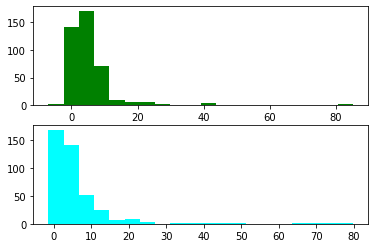

In [19]:
err_lung = np.array(angle_errors)[:, 0]
err_heart = np.array(angle_errors)[:, 1]
plt.figure()
plt.subplot(211)
plt.hist(err_lung, bins=20, color='green')
plt.subplot(212)
plt.hist(err_heart, bins=20, color='cyan')

# For paper visualization

In [34]:
filelist = [
    'normal_0032.png',
    'normal_0033.png',
    'normal_0100.png',
    'normal_0124.png',
    'normal_0661.png'
]

save_pred_folder = './ablation/'


save_image = True
with_gt = False
with_box = False
angle_errors = []
dices = []
ious = []
bbox_ious = []
ratios_pred = []
ratios_gt = []
ctr_precisions = []

for ind in range(len(dataset)):
    # Load Image

    cls_dice = []
    cls_angle_error = []
    cls_iou = []
    cls_bbox_iou = []
    diameter_gt = [1, 1]
    diameter_pred = [1, 1]

    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    shape = image.shape[:2]
    
    if img_info['file_name'] not in filelist:
        continue

    # Load annotations
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        try:
            class_id = class_idx + 1
            pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
            pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
            cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
            l = int(ret['results'][class_id][0, 6]) # !attention here!
            ratio_al = ret['results'][class_id][0, 7]
            ratio_bl = ret['results'][class_id][0, 8]
            a = ratio_al * l / 2
            b = ratio_bl * l / 2
            theta = ret['results'][class_id][0, 9]
            angle = theta * 180
            print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_bl, "({})'".format(theta), int(a), int(b), int(angle))

            # Annotations
            ann = anns[class_idx]
            cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
            theta_gt = theta_gt / math.pi
            theta_gt = theta_gt - 1 if theta_gt > 0.5 else theta_gt + 1 if theta_gt < -0.5 else theta_gt
            l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
            pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
            pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
            ratio_al, ratio_bl = 2 * a_gt / l_gt, 2 * b_gt / l_gt
            angle_gt = theta_gt * 180
            print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_bl, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
            if with_gt and with_box:
                img = cv2.rectangle(image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
            if with_gt:
                img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0), thickness=2)
        #     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
        #     img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)


            pt1 = (int(cx - l / 2), int(cy - l / 2))
            pt2 = (int(cx + l / 2), int(cy + l / 2))
            if with_box:
                img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
            img = cv2.ellipse(image, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

            pred_ell = [cx, cy, a, b, angle]
            gt_ell = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
            error = compute_single_class_metric(pred_ell, gt_ell, shape)
            print("dice: {}  iou:{}  bbox_iou: {}  angle_error: {}".format(error[0], error[1], error[2], error[3]))
            diameter_pred[class_idx] = b
            diameter_gt[class_idx] = b_gt
            cls_dice.append(error[0])
            cls_iou.append(error[1])
            cls_bbox_iou.append(error[2])
            cls_angle_error.append(error[3])

        except Exception as e:
            print(e)
            cls_dice.append(0)
            cls_iou.append(0)
            cls_bbox_iou.append(0)
            cls_angle_error.append(90)
            pass

    if save_image:
        img = Image.fromarray(image)
        img.save(os.path.join(save_pred_folder, img_path.split('/')[-1]))
        print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
    dices.append(cls_dice)
    ious.append(cls_iou)
    bbox_ious.append(cls_bbox_iou)
    angle_errors.append(cls_angle_error)
    try:
        ratio_p, ratio_g = float(diameter_pred[1]) / diameter_pred[0], float(diameter_gt[1]) / diameter_gt[0]
        ctr_precision = 1 - abs(ratio_p - ratio_g) / ratio_g
    except Exception as e:
        ctr_precision = 0
        ratio_p = 0
    print("predicted ratio: {}, truth ratio: {}, error: {}, precision: {}".format(ratio_p, ratio_g, abs(ratio_p - ratio_g), ctr_precision))
    ratios_pred.append(ratio_p)
    ratios_gt.append(ratio_g)
    ctr_precisions.append(ctr_precision)
    # break

Predict:      (90, -63) (760, 606) (425, 271) 670 0.80187404 0.6107166 (0.037225645035505295)' 268 204 6
Ground Truth: (96, -63) (765, 605) (431, 271) 669.1665837562423 0.7926217669488523 0.6097136496412714 (0.056847807237428216)' 265 204 10
name 'compute_single_class_metric' is not defined
Predict:      (348, 93) (691, 435) (519, 264) 342 0.79769695 0.5889566 (-0.12156718969345093)' 136 100 -21
Ground Truth: (363, 105) (680, 422) (522, 264) 317.64191320416137 0.8060397238428602 0.5918614395171609 (-0.1609351400195277)' 128 94 -28
name 'compute_single_class_metric' is not defined
Saving /data/cc/Data/CHD/detection/images/normal_0032.png to ./ablation/normal_0032.png
predicted ratio: 1.0, truth ratio: 1.0, error: 0.0, precision: 1.0
Predict:      (146, -75) (816, 594) (481, 259) 670 0.79927397 0.6150806 (0.05309740826487541)' 267 206 9
Ground Truth: (162, -60) (795, 572) (479, 256) 632.974693509938 0.7750199258041868 0.6319367963700745 (0.052202821334141676)' 245 200 9
name 'compute_sin

In [158]:
dices

[[0.9299634954160939, 0.9256375281124264],
 [0.9502288272981095, 0.8538003680097701],
 [0.9471889848351555, 0.6420789677409052],
 [0.961675231863847, 0.9315834357690742],
 [0.9475476682824306, 0.769730984948765],
 [0.9648238350849353, 0.9410642464316117],
 [0.8518621754097466, 0.8946814111849581],
 [0.9496191714216228, 0.9180043254935477],
 [0.8899719249824246, 0.8305327671916716],
 [0.9059321713200899, 0.8053884054088072],
 [0.7277319888349941, 0.5032505691371301],
 [0.878973909948452, 0.9112355712342034],
 [0.8468087402855471, 0.9440862765568317],
 [0.8851101875136055, 0.8104611050282022],
 [0.9560367413970163, 0.9058080181445353],
 [0.6547020364652733, 0.8792698354977145],
 [0.7867316465423981, 0.8209942361425817],
 [0.8926975315314682, 0.9204288692087877],
 [0.92859228117175, 0.7282394929957],
 [0.933676976703481, 0.9040398589013562],
 [0.9417726024252532, 0.8675208010553332],
 [0.9201061699117465, 0.9246030392682832],
 [0.8509293036601179, 0.9039082080107989],
 [0.9095776721467914

# With Ground Truth

/data/cc/Data/CHD/detection/images/abnormal_0058.png
(-704, -678) (1132, 1158) (213, 239) 459 0.39113346 0.7888333 0.5965246 179.53025695681572 141.61944866098284 107
(-215, -254) (689, 651) (236, 198) 226 0.34028825 0.90244985 0.72942054 76.90514487028122 69.4030361653805 131


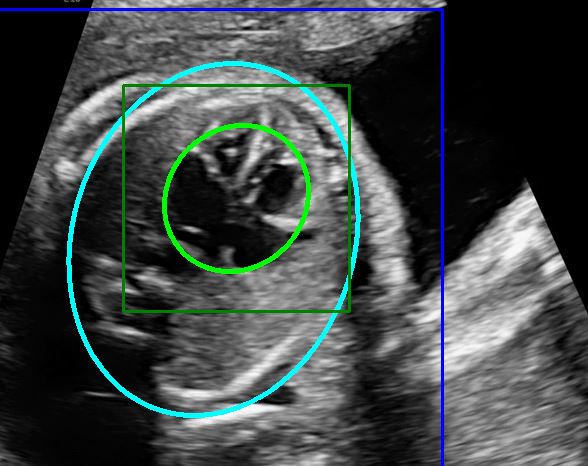

In [18]:
ind += 1



# Load Image
img_id = dataset.images[ind]
img_info = dataset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(dataset.img_dir, img_info['file_name'])
image = cv2.imread(img_path)
print(img_path)

# Load annotations
# ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
# anns = dataset.coco.loadAnns(ids=ann_ids)

# Inference
color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
ret = detector.run(img_path)

for class_idx in range(opt.num_classes):
    class_id = class_idx + 1
    pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
    pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
    cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
    l = int(ret['results'][class_id][0, 6] / 4) # !attention here!
    ratio_al = ret['results'][class_id][0, 7]
    ratio_ba = ret['results'][class_id][0, 8]
    a = ratio_al * l
    b = ratio_ba * a
    theta = ret['results'][class_id][0, 9]
    angle = theta * 180
    print(pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, theta, a, b, int(angle))
    
    pt1 = (int(cx - l / 2), int(cy - l / 2))
    pt2 = (int(cx + l / 2), int(cy + l / 2))
    img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
    img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)
    
img = Image.fromarray(image)
img
img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

In [146]:
len(dataset.images)

100

In [147]:
for ind in range(len(dataset.images)):

    # Load Image
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    print(img_path)

    # Load annotations
    # ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    # anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    red = (255, 0, 0)
    green = (0, 255, 0)
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        class_id = class_idx + 1
        pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
        pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
        cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
        l = int(ret['results'][class_id][0, 6] / 4) # !attention here!
        ratio_al = ret['results'][class_id][0, 7]
        ratio_ba = ret['results'][class_id][0, 8]
        a = ratio_al * l
        b = ratio_ba * a
        theta = ret['results'][class_id][0, 9]
        angle = theta * 180
        print(pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, theta, a, b, int(angle))

        pt1 = (int(cx - l / 2), int(cy - l / 2))
        pt2 = (int(cx + l / 2), int(cy + l / 2))
        img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
        img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

    img = Image.fromarray(image)
    img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

/data/cc/Data/CHD/detection/images/abnormal_0000.png
(-936, -1078) (1752, 1610) (408, 265) 672 0.38649797 0.8034471 0.59329367 259.7266387939453 208.67662183324683 106
(-185, -443) (1156, 898) (485, 227) 335 0.37068468 0.845624 0.7307339 124.17936891317368 105.00905833806092 131


/home/cc/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/cc/Data/CHD/detection/images/abnormal_0001.png
(-1316, -1272) (1915, 1958) (299, 342) 807 0.38554302 0.7937233 0.63559026 311.1332159936428 246.95367833275895 114
(-571, -638) (1256, 1189) (342, 275) 456 0.33497074 0.92716104 0.7286147 152.7466585636139 141.62075049294316 131
/data/cc/Data/CHD/detection/images/abnormal_0002.png
(-685, -837) (1439, 1287) (377, 224) 531 0.37524202 0.83682317 0.6011875 199.25351509451866 166.73995722180283 108
(-284, -431) (938, 790) (327, 179) 305 0.35961708 0.8853992 0.6915283 109.68321070075035 97.11342946192383 124
/data/cc/Data/CHD/detection/images/abnormal_0003.png
(-692, -752) (1530, 1470) (418, 358) 555 0.39406824 0.78408897 0.555698 218.70787382125854 171.48643134713808 100
(2, -134) (973, 836) (487, 350) 242 0.40083143 0.7550271 0.67525923 97.00120633840561 73.23854100667164 121
/data/cc/Data/CHD/detection/images/abnormal_0004.png
(-519, -769) (1604, 1353) (542, 292) 530 0.39346087 0.7875335 0.55879354 208.53426098823547 164.2277209412086 

/data/cc/Data/CHD/detection/images/abnormal_0032.png
(-806, -967) (1589, 1427) (391, 230) 598 0.38490686 0.81165266 0.5962233 230.17430120706558 186.82158392349126 107
(-206, -404) (939, 741) (366, 168) 286 0.35623533 0.889675 0.6737016 101.8833030462265 90.64302979468103 121
/data/cc/Data/CHD/detection/images/abnormal_0033.png
(-909, -1115) (2023, 1817) (557, 350) 733 0.39270958 0.7791342 0.5783564 287.8561243712902 224.27855518535182 104
(-323, -462) (1273, 1134) (475, 335) 399 0.39549834 0.7689658 0.67642796 157.8038358092308 121.34574980602542 121
/data/cc/Data/CHD/detection/images/abnormal_0034.png
(-1166, -1531) (2495, 2130) (664, 299) 915 0.39691207 0.759723 0.5908772 363.174542337656 275.9120556172031 106
(-466, -761) (1548, 1253) (540, 246) 503 0.38555905 0.8128723 0.67110515 193.9362032711506 157.64536578547248 120
/data/cc/Data/CHD/detection/images/abnormal_0035.png
(-847, -983) (1615, 1480) (383, 248) 615 0.3936838 0.7713871 0.5814489 242.11553156375885 186.76479781112562 1

/data/cc/Data/CHD/detection/images/normal_0011.png
(-719, -946) (1796, 1569) (538, 311) 629 0.38840213 0.8016191 0.56186837 244.30494239926338 195.83951110341084 101
(-210, -377) (1151, 984) (470, 303) 340 0.4012519 0.76307815 0.67414427 136.4256501197815 104.10343313342523 121
/data/cc/Data/CHD/detection/images/normal_0012.png
(-1047, -1337) (2353, 2063) (653, 362) 850 0.3799395 0.82476175 0.58279085 322.9485720396042 266.35562889086265 104
(-284, -566) (1415, 1133) (565, 283) 424 0.35486376 0.8842327 0.67831975 150.46223545074463 133.04362868124753 122
/data/cc/Data/CHD/detection/images/normal_0013.png
(-1328, -1566) (2431, 2192) (551, 313) 939 0.38674694 0.7987437 0.6216092 363.15537947416306 290.0680804907023 111
(-521, -632) (1519, 1408) (498, 388) 510 0.38006058 0.8119076 0.67992705 193.83089751005173 157.37277675552056 122
/data/cc/Data/CHD/detection/images/normal_0014.png
(-656, -762) (1483, 1378) (413, 307) 535 0.3723557 0.8542538 0.5708149 199.21029925346375 170.1761608189905

/data/cc/Data/CHD/detection/images/normal_0041.png
(-848, -933) (1656, 1571) (404, 318) 626 0.38553208 0.80070436 0.5949264 241.34308278560638 193.24445864426457 107
(-246, -325) (957, 878) (355, 276) 300 0.38648233 0.8026103 0.67156076 115.94469845294952 93.05840667297183 120
/data/cc/Data/CHD/detection/images/normal_0042.png
(-868, -1035) (1905, 1738) (518, 351) 693 0.38248134 0.8247764 0.6210107 265.05956625938416 218.61487777561234 111
(-188, -292) (1073, 970) (442, 339) 315 0.3993388 0.7493425 0.67513514 125.79172566533089 94.2610863357297 121
/data/cc/Data/CHD/detection/images/normal_0043.png
(-548, -723) (1527, 1352) (489, 314) 519 0.3818812 0.83510983 0.56738937 198.1963465511799 165.5157172556823 102
(-193, -316) (1142, 1019) (474, 351) 334 0.38090873 0.84981287 0.58829707 127.22351503372192 108.11617983890773 105
/data/cc/Data/CHD/detection/images/normal_0044.png
(-990, -1014) (1564, 1540) (286, 262) 638 0.40253827 0.749724 0.6030265 256.8194161057472 192.54367244446362 108
(

In [145]:
img = Image.fromarray(image)
img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

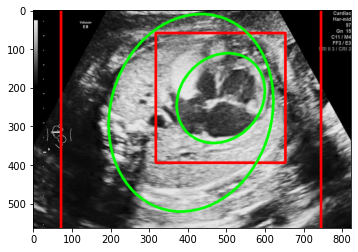

In [37]:
# image = np.array(Image.open(img_path).convert('RGB'))
lung_pt1 = (int(cx - l / 2), int(cy - l / 2))
lung_pt2 = (int(cx + l / 2), int(cy + l / 2))
img = cv2.rectangle(img=image, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, (0, 255, 0), thickness=5)
# img = cv2.rectangle(img=img, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
    
plt.imshow(image)

In [14]:
preprocessed_image, meta = detector.pre_process(image, scale=1.0)
preprocessed_image = preprocessed_image.to(opt.device)
preprocessed_image.shape

torch.Size([1, 3, 512, 512])

In [15]:
output = model(preprocessed_image)[-1]

In [ ]:
print(output['hm'].shape, output['reg'].shape, output['l'].shape, output['ratio_al'].shape, output['ratio_ba'].shape, output['theta'].shape)

In [ ]:
from models.decode import _nms, _left_aggregate, _right_aggregate, _top_aggregate, \
                        _bottom_aggregate, _h_aggregate, _v_aggregate, _topk_channel, \
                        _topk
from models.utils import _gather_feat, _transpose_and_gather_feat

In [ ]:
def test_eldet_decode(heat, l, ratio_al, ratio_ba, theta, reg=None, cat_spec_wh=False, K=2): # Decode ellipse information
    batch, cat, height, width = heat.size()

    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
      
    scores, inds, clses, ys, xs = _topk(heat, K=K)
    if reg is not None:
      reg = _transpose_and_gather_feat(reg, inds)
      reg = reg.view(batch, K, 2)
      xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
      ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
      xs = xs.view(batch, K, 1) + 0.5
      ys = ys.view(batch, K, 1) + 0.5
    l = _transpose_and_gather_feat(l, inds)
    ratio_al = _transpose_and_gather_feat(ratio_al, inds)
    ratio_ba = _transpose_and_gather_feat(ratio_ba, inds)
    theta = _transpose_and_gather_feat(theta, inds)
    if cat_spec_wh:
      l = l.view(batch, K, cat, 1)
      clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
      l = l.gather(1, clses_ind).view(batch, K, 1)
    else:
      l = l.view(batch, K, 1)
    clses  = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)
    bboxes = torch.cat([xs - l / 2, 
                        ys - l / 2,
                        xs + l / 2, 
                        ys + l / 2], dim=2)
#     print(bboxes.shape, scores.shape, clses.shape, xs.shape, ys.shape, l.shape, ratio_al.shape, ratio_ba.shape, theta.shape)
#     print('bboxes:', bboxes, 'scores:', scores, 'clses:', clses, 'xs:', xs, 'ys:', ys, 'l:', l, 'ratio_al:', ratio_al, 'ratio_ba:', ratio_ba, 'theta:', theta)
    detections = torch.cat([bboxes, scores, clses, xs, ys, l, ratio_al, ratio_ba, theta], dim=2) # batch x max_dets x dim
      
    return detections

In [ ]:
def transform_preds(coords, center, scale, output_size):
    target_coords = np.zeros(coords.shape)
    trans = get_affine_transform(center, scale, 0, output_size, inv=1)
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = affine_transform(coords[p, 0:2], trans)
    return target_coords

def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale], dtype=np.float32)

    scale_tmp = scale
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5], np.float32) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans

def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result

def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)


In [ ]:
# output -> detection
hm = output['hm'].sigmoid_()
l = output['l']
ratio_al = output["ratio_al"]
ratio_ba = output["ratio_ba"]
theta = output["theta"]
reg = output['reg'] if opt.reg_offset else None

dets = test_eldet_decode(hm, l, ratio_al, ratio_ba, theta, reg=reg)
dets

In [ ]:
[meta['c']], [meta['s']], meta['out_height'], meta['out_width'], opt.num_classes

In [ ]:
ret = []
i = 0
num_classes = 2
top_preds = {}
c, s, h, w, num_classes = [meta['c']], [meta['s']], meta['out_height'], meta['out_width'], opt.num_classes

print("Origin:", dets)
dets[i, :, :2] = transform_preds(
      dets[i, :, 0:2], c[i], s[i], (w, h))
dets[i, :, 2:4] = transform_preds(
      dets[i, :, 2:4], c[i], s[i], (w, h))
print("Transformed:", dets)
classes = dets[i, :, -1]
for j in range(num_classes):
  inds = (classes == j)
  top_preds[j + 1] = np.concatenate([
    dets[i, inds, :4].astype(np.float32),
    dets[i, inds, 4:5].astype(np.float32)], axis=1).tolist()
ret.append(top_preds)

In [ ]:
classes

In [ ]:
# eldet post processing
def eldet_post_process(dets, c, s, h, w, num_classes):
  # dets: batch x max_dets x dim
  # return 1-based class det dict
  ret = []
  for i in range(dets.shape[0]):
    top_preds = {}
    dets[i, :, :2] = transform_preds(
          dets[i, :, 0:2], c[i], s[i], (w, h))
    dets[i, :, 2:4] = transform_preds(
          dets[i, :, 2:4], c[i], s[i], (w, h))
    classes = dets[i, :, -1]
    for j in range(num_classes):
      inds = (classes == j)
      top_preds[j + 1] = np.concatenate([
        dets[i, inds, :4].astype(np.float32),
        dets[i, inds, 4:5].astype(np.float32)], axis=1).tolist()
    ret.append(top_preds)
  return ret

In [ ]:
dets = dets.detach().cpu().numpy()
dets = dets.reshape(1, -1, dets.shape[2])
dets = eldet_post_process(
    dets.copy(), [meta['c']], [meta['s']],
    meta['out_height'], meta['out_width'], self.opt.num_classes)
for j in range(1, self.num_classes + 1):
  dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
  dets[0][j][:, :4] /= scale

In [ ]:
def post_process(self, dets, meta, scale=1):
    dets = dets.detach().cpu().numpy()
    dets = dets.reshape(1, -1, dets.shape[2])
    dets = eldet_post_process(
        dets.copy(), [meta['c']], [meta['s']],
        meta['out_height'], meta['out_width'], self.opt.num_classes)
    for j in range(1, self.num_classes + 1):
      dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
      dets[0][j][:, :4] /= scale
    return dets[0]

In [ ]:
batch, cat, height, width = hm.size()
heat = _nms(hm)
scores, inds, clses, ys, xs = _topk(heat, K=2)
scores, inds, clses, ys, xs

In [ ]:
reg.shape, inds

In [ ]:
K = 2
cat_spec_wh = False
if reg is not None:
  reg = _transpose_and_gather_feat(reg, inds)
  reg = reg.view(batch, K, 2)
  xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
  ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
else:
  xs = xs.view(batch, K, 1) + 0.5
  ys = ys.view(batch, K, 1) + 0.5
l = _transpose_and_gather_feat(l, inds)
if cat_spec_wh:
  l = l.view(batch, K, cat, 1)
  clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
  l = l.gather(1, clses_ind).view(batch, K, 1)
else:
  l = l.view(batch, K, 1)
clses  = clses.view(batch, K, 1).float()
scores = scores.view(batch, K, 1)

In [ ]:
results = {}
num_iters = len(dataset)
bar = Bar('{}'.format(opt.exp_id), max=num_iters)
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
avg_time_stats = {t: AverageMeter() for t in time_stats}
for ind in range(num_iters):
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])

    if opt.task == 'ddd':
        ret = detector.run(img_path, img_info['calib'])
    else:
        ret = detector.run(img_path)

    results[img_id] = ret['results']

    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
        avg_time_stats[t].update(ret[t])
        Bar.suffix = Bar.suffix + '|{} {:.3f} '.format(t, avg_time_stats[t].avg)
    bar.next()
bar.finish()
dataset.run_eval(results, opt.save_dir)

In [ ]:
results

In [ ]:
print(img_id)
img_info = dataset.coco.loadImgs(ids=[img_id])[0]

# Inference

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
test_image_folder = '/data/cc/Data/CHD/detection/images/'
image_lists = sorted(glob(os.path.join(test_image_folder, "*.png")))
save_folder = '/data/cc/Data/CHD/detection/predictions/'

In [ ]:
idx = 0
for img_path in image_lists:
    
    idx += 1
    
    img_name = img_path.split('/')[-1]
    ret = detector.run(img_path)
    
    lung_pt1 = (int(ret['results'][1][0][0]), int(ret['results'][1][0][1]))
    lung_pt2 = (int(ret['results'][1][0][2]), int(ret['results'][1][0][3]))
    heart_pt1 = (int(ret['results'][2][0][0]), int(ret['results'][2][0][1]))
    heart_pt2 = (int(ret['results'][2][0][2]), int(ret['results'][2][0][3]))
    
    image = np.array(Image.open(img_path).convert('RGB'))
    img = cv2.rectangle(img=image, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
    img = cv2.rectangle(img=img, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
    
    result = Image.fromarray(img)
    result.save(os.path.join(save_folder, img_name))
    
    print("Processing img: {}, shape:{}, Lung pt1:{} pt2:{}, Heart pt1:{}, pt2:{}".format(img_name, image.shape, lung_pt1, lung_pt2, heart_pt1, heart_pt2))
    
#     if idx > 1:
#         break


In [ ]:
ret

In [ ]:
lung_pt1 = (int(ret['results'][1][0][0]), int(ret['results'][1][0][1]))
lung_pt2 = (int(ret['results'][1][0][2]), int(ret['results'][1][0][3]))
heart_pt1 = (int(ret['results'][2][0][0]), int(ret['results'][2][0][1]))
heart_pt2 = (int(ret['results'][2][0][2]), int(ret['results'][2][0][3]))

In [ ]:
img = np.array(Image.open(img_path).convert('RGB'))
plt.imshow(img)

In [ ]:
img_path

In [ ]:
l = img[:]
l = cv2.rectangle(img=l, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
l = cv2.rectangle(img=l, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
plt.imshow(l)

In [ ]:
result = Image.fromarray(l)
result.save(os.path.join(save_folder, img_name))

# Rotated IoU

In [18]:
import math
from torch import nn, optim
import argparse
from utiles import box2corners
from oriented_iou_loss import cal_diou, cal_giou

In [16]:
output

{'hm': tensor([[[[-4.3433, -5.5296, -5.5170,  ..., -5.3087, -5.2807, -4.2913],
           [-5.4693, -7.2061, -7.2195,  ..., -6.9011, -6.8778, -5.3490],
           [-5.4691, -7.1824, -7.1806,  ..., -6.9330, -6.8808, -5.4019],
           ...,
           [-5.2143, -6.8130, -6.8661,  ..., -7.1894, -7.0903, -5.5019],
           [-5.3262, -6.8891, -6.8383,  ..., -7.1273, -7.0633, -5.4696],
           [-4.3603, -5.3907, -5.3109,  ..., -5.4597, -5.4542, -4.3752]],
 
          [[-4.4292, -5.5015, -5.5068,  ..., -5.3757, -5.3183, -4.2863],
           [-5.4769, -7.0954, -7.1240,  ..., -6.9488, -6.8777, -5.3009],
           [-5.4566, -7.0729, -7.0850,  ..., -6.9706, -6.9265, -5.3418],
           ...,
           [-5.1941, -6.6772, -6.7317,  ..., -7.1623, -7.0690, -5.4433],
           [-5.2653, -6.7094, -6.6905,  ..., -7.0680, -7.0011, -5.3971],
           [-4.2260, -5.1407, -5.1102,  ..., -5.3456, -5.3033, -4.3035]]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 'reg': tensor([[[[0.5947, 0.8

In [42]:
bbox1 = torch.tensor([[[125, 125, 100, 50, math.pi]]]).cuda()
bbox2 = torch.tensor([[[125, 125, 100, 50, 0.0 * math.pi]]]).cuda()
print(bbox1.shape, bbox2.shape)
print(bbox1, bbox2)
iou_loss, iou = cal_diou(bbox1, bbox2)
iou_loss, iou

torch.Size([1, 1, 5]) torch.Size([1, 1, 5])
tensor([[[125.0000, 125.0000, 100.0000,  50.0000,   3.1416]]], device='cuda:0') tensor([[[125., 125., 100.,  50.,   0.]]], device='cuda:0')


(tensor([[0.]], device='cuda:0'), tensor([[1.]], device='cuda:0'))

In [252]:
# Using ratio_bl

angle_errors = []
dices = []
ious = []
bbox_ious = []


for ind in range(len(dataset)):
    ind = 34
    # Load Image
    
    cls_dice = []
    cls_angle_error = []
    cls_iou = []
    cls_bbox_iou = []
    
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    shape = image.shape[:2]

    # Load annotations
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        try:
            class_id = class_idx + 1
            pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
            pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
            cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
            l = int(ret['results'][class_id][0, 6]) # !attention here!
            ratio_al = ret['results'][class_id][0, 7]
            ratio_bl = ret['results'][class_id][0, 8]
            a = ratio_al * l / 2
            b = ratio_bl * l / 2
            theta = ret['results'][class_id][0, 9]
            angle = theta * 180
            print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_bl, "({})'".format(theta), int(a), int(b), int(angle))

            # Annotations
            ann = anns[class_idx]
            cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
            theta_gt = theta_gt / math.pi
            theta_gt = theta_gt - 1 if theta_gt > 0.5 else theta_gt + 1 if theta_gt < -0.5 else theta_gt
            l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
            pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
            pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
            ratio_al, ratio_bl = 2 * a_gt / l_gt, 2 * b_gt / l_gt
            angle_gt = theta_gt * 180
            print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_bl, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
#             img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
            img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color=color_maps[class_idx * 2 + 1], thickness=2)
        #     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
        #     img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)


            pt1 = (int(cx - l / 2), int(cy - l / 2))
            pt2 = (int(cx + l / 2), int(cy + l / 2))
#             img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
#             img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

            pred_ell = [cx, cy, a, b, angle]
            gt_ell = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
            error = compute_single_class_metric(pred_ell, gt_ell, shape)
            print("dice: {}  iou:{}  bbox_iou: {}  angle_error: {}".format(error[0], error[1], error[2], error[3]))
            cls_dice.append(error[0])
            cls_iou.append(error[1])
            cls_bbox_iou.append(error[2])
            cls_angle_error.append(error[3])
            
        except Exception as e:
            print(e)
            cls_dice.append(0)
            cls_iou.append(0)
            cls_bbox_iou.append(0)
            cls_angle_error.append(90)
            pass
    img = Image.fromarray(img)
    img.save('label.png')
#     print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
#     img.save(os.path.join(save_pred_folder, img_path.split('/')[-1]))
#     print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
    dices.append(cls_dice)
    ious.append(cls_iou)
    bbox_ious.append(cls_bbox_iou)
    angle_errors.append(cls_angle_error)
#     img
    break


Predict:      (-37, -44) (794, 788) (378, 372) 832 0.49633774 0.36814708 (0.0029389741830527782)' 206 153 0
Ground Truth: (8, -46) (821, 766) (415, 360) 813.2595489854392 0.7924850077739932 0.6098913939821203 (0.08804217608343967)' 322 248 15
dice: 0.5669879778891793  iou:0.39566170355919866  bbox_iou: 0.3956793546676636  angle_error: 15.31857634206964
Predict:      (196, 35) (811, 651) (504, 343) 615 1.0 0.98237014 (0.0009649893036112189)' 307 302 0
Ground Truth: (279, 119) (726, 566) (503, 343) 446.29608288668635 0.8290460395861065 0.5591803503759695 (-0.15087888605111677)' 185 124 -27
dice: 0.39796982738597514  iou:0.2484159375953636  bbox_iou: 0.24851427972316742  angle_error: 27.331897563851037
